<a href="https://colab.research.google.com/github/sssylvia0/Uplift_Model/blob/main/NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# check pytorch version
import torch
print(torch.__version__)

2.2.1+cu121


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Lift model

模型架構圖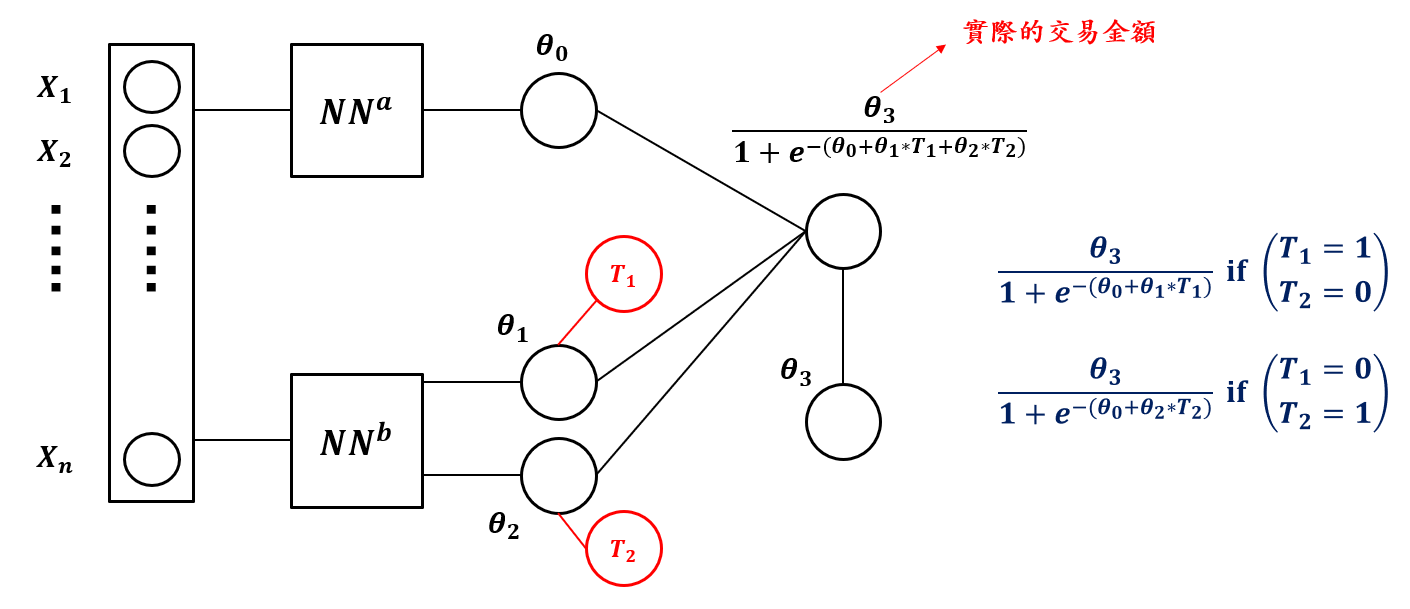

In [5]:
import zipfile

# Specify the path to the zip file
#zip_file_path = 'data202305.csv.zip'
zip_file_path = '/content/drive/MyDrive/Sinopac/Rawdata/data202402_new.csv.zip'


# Unzip the folder
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')
print("Unzipped successfully.")

Unzipped successfully.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#df = pd.read_csv('/content/drive/MyDrive/Sinopac/train_202402.csv')
df = pd.read_csv('/content/data202402_new.csv', index_col = 0)
df

,UNINO,年齡,公司戶記號,性別,呆帳記號_含信用卡,客戶年收入,網路會員記號,網路使用記號_行動銀行,小mma記號,網路服務記號,...,客戶行業別_醫療保健,客戶行業別_金融業,客戶行業別_電子業,對帳單寄送記號_0,對帳單寄送記號_1,對帳單寄送記號_2,信用卡VIP客戶註記_Y,外幣存款記號_Y,信用卡轉呆記號_Y,信用卡自動扣款記號_Y
0,H8223079220,48,0,1.0,0,3000.0,1,1,0,1,...,False,False,False,False,False,True,False,True,False,False
1,K2779339830,39,0,2.0,0,500.0,1,3,0,1,...,False,False,False,False,False,True,False,False,False,False
2,K2779343760,36,0,2.0,0,0.0,1,3,0,1,...,False,False,False,False,False,True,False,True,False,False
3,K2779417370,35,0,2.0,0,360.0,1,2,0,1,...,False,False,False,False,False,True,False,True,False,False
4,L2727403190,51,0,2.0,0,650.0,1,2,0,1,...,True,False,False,False,False,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103735,J2725993350,61,0,2.0,0,0.0,1,0,0,8,...,False,False,False,True,False,False,False,False,False,False
1103736,J2725446790,50,0,2.0,0,0.0,1,0,0,6,...,False,False,False,True,False,False,False,False,False,False
1103737,J2726228250,56,0,2.0,0,0.0,1,2,0,1,...,False,False,False,False,False,True,False,True,False,False
1103738,H2711308250,23,0,2.0,0,280.0,1,2,0,3,...,False,False,False,False,False,True,False,False,False,False


In [2]:
df.select_dtypes(include=['object']).columns

Index(['UNINO'], dtype='object')

In [25]:
binary_columns = []

for column in df.columns:
    unique_values = df[column].unique()
    if len(unique_values) <= 2 and (0 in unique_values or 1 in unique_values):
        binary_columns.append(column)

print("Columns with binary values:")
print(binary_columns)
print(len(binary_columns)) #69

# Convert columns to object data type
df[binary_columns] = df[binary_columns].astype('int64')

Columns with binary values:
['公司戶記號', '性別', '呆帳記號_含信用卡', '網路會員記號', '網路使用記號', '薪轉戶記號', '銀行靜止戶記號', '停滯戶記號', '催收記號_不含信用卡', '上市櫃公司員工記號', '融資年交易額', '融資三月交易額', '融資六月交易額', '融資庫存市值', '融資使用金額', '融券庫存市值', '融券使用金額', '存款記號', '信貸記號', '房貸記號', '信用卡最近一個月收單手續費收入', '員工記號', '金控員工記號_非銀行', '台幣定期性總存款', '外幣定期性總存款', '放款總餘額信貸', '放款總餘額房貸', '撥款總額信貸', '撥款總額房貸', '無擔保額度', '有擔保額度', '撥款總額_理財房貸_343547', '撥款總額_一般房貸_36', '當月放款手續費', '當月房貸壽險貸款AP', '當月證券AP', '當月信託AP', '當月基金AP收入', '保險當月傭金_要保人', '當月一般匯差收入', '當年度放款手續費', '當年房貸壽險貸款AP', '當年度證券AP', '當年度信託AP', '當年度基金申購手續費', '當年度基金匯差收入', '保險當年傭金_要保人', '當年度一般匯差收入', '當年度保險佣金金額_被保人', '當年度保險佣金金額_要保人', '最近一個月平均餘額_台幣定期性存款', '最近三個月平均餘額_台幣定期性存款', '最近一年平均餘額_台幣定期性存款', '外幣存單最近一個月平均餘額', '外幣存單最近三個月平均餘額', '庫存基金投資收益', '庫存基金投資現值', '庫存基金原始投資金額', '當月基金申購手續費', '當月基金匯差收入', '最近一個月平均餘額_庫存基金原始投資金額', '最近一個月平均餘額_海外債券原始投資金額', '最近一個月平均信託投資金額', '基金近1個月申購金額', '基金近3個月申購金額', '基金近6個月申購金額', '基金近12個月申購金額', '基金近1個月申購次數', '基金近3個月申購次數', '基金近6個月申購次數', '基金近12個月申購次數', '基金近1個月單筆申購金額', '基金近12個月單筆申購金額', '定時定額近1個月扣款總額', '定時定

In [3]:
num_cols = ['年齡', '薪轉員工平均薪資', '全行往來產品數_持有', '全行往來產品數_使用', '基金近1個月申購次數', '基金近3個月申購次數',
       '基金近6個月申購次數', '基金近12個月申購次數', '最近一個月刷卡筆數', '最近三個月刷卡筆數', '最近六個月刷卡筆數',
       '共同行銷合作推廣_證券', '證券月交易筆數', '證券近一年交易筆數', '證券庫存股檔數', 'TOTALNTAMOUNT',
       '外匯交易金額_近三個月']
#df.select_dtypes(include=['int64']).columns[~df.select_dtypes(include=['int64']).columns.isin(binary_columns)] #111

In [4]:
#1. Minmax
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Exclude non-numeric columns if any
numeric_cols = df.select_dtypes(include=['float64']).columns
numeric_cols = list(numeric_cols)+(num_cols) #128
#numeric_cols.append(num_cols)
# Initializing MinMaxScaler
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

train, test = train_test_split(df, test_size=0.2, random_state=42)
train.drop(['UNINO'], axis = 1, inplace = True)
unino = test['UNINO']
test.drop(['UNINO'], axis = 1, inplace = True)
print(train.shape, test.shape)

(882992, 204) (220748, 204)


In [11]:
#1. Minmax
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Exclude non-numeric columns if any
numeric_cols = df.select_dtypes(include=['float64']).columns
numeric_cols = numeric_cols.tolist()  # Convert Index to list

# Concatenate the lists of column names
numeric_cols += num_cols

# Assuming df is your DataFrame and columns_to_winsorize contains the column names you want to winsorize
for col in numeric_cols:
    df[col] = winsorize(df[col], limits=(0.05, 0.05))

# Initializing MinMaxScaler
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

train, test = train_test_split(df, test_size=0.2, random_state=42)
train.drop(['UNINO'], axis = 1, inplace = True)
unino = test['UNINO']
test.drop(['UNINO'], axis = 1, inplace = True)
print(train.shape, test.shape)

(882992, 204) (220748, 204)


In [9]:
#Normalize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Exclude non-numeric columns if any
numeric_cols = df.select_dtypes(include=['float64']).columns #139

# Initialize StandardScaler
scaler = StandardScaler()
# Fit scaler on the entire numeric data
scaler.fit(df[numeric_cols])
df[numeric_cols].append(df[num_cols])
# Transform the entire numeric data
df[numeric_cols] = scaler.transform(df[numeric_cols])

# Split the data into training and testing sets
train, test = train_test_split(df, test_size=0.2, random_state=42)
# Drop the 'UNINO' column from both train and test sets
train.drop(['UNINO'], axis=1, inplace=True)
unino = test['UNINO']
test.drop(['UNINO'], axis=1, inplace=True)

print(train.shape, test.shape)

AttributeError: 'DataFrame' object has no attribute 'append'

In [28]:
df[numeric_cols]

,年齡,客戶年收入,薪轉員工平均薪資,信用卡有效主卡張數,全行往來產品數_持有,全行往來產品數_使用,台幣活期性總存款,外幣活期性總存款,台幣總存款,外幣總存款,...,基金近12個月申購次數,最近一個月刷卡筆數,最近三個月刷卡筆數,最近六個月刷卡筆數,共同行銷合作推廣_證券,證券月交易筆數,證券近一年交易筆數,證券庫存股檔數,TOTALNTAMOUNT,外匯交易金額_近三個月
0,0.625000,1.000000,0.0,0.0,0.000000,0.333333,0.074844,0.013283,0.057933,0.005525,...,0.0,0.0,0.0000,0.00000,0.5,0.0,0.0,0.0,0.0,0.0
1,0.437500,0.357143,0.0,0.0,0.000000,0.333333,0.000056,0.000000,0.000043,0.000000,...,0.0,0.0,0.0000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.375000,0.000000,0.0,0.5,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0000,0.00000,0.5,0.0,0.0,0.0,0.0,0.0
3,0.354167,0.257143,0.0,0.0,0.333333,0.333333,0.508298,0.000000,0.393450,0.000000,...,0.0,0.0,0.0000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.687500,0.464286,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103735,0.895833,0.000000,0.0,0.5,0.333333,0.666667,0.000277,0.000000,0.000214,0.000000,...,0.0,0.0,0.0625,0.03125,1.0,0.0,0.0,0.0,0.0,0.0
1103736,0.666667,0.000000,0.0,0.0,0.000000,0.333333,0.006341,0.000000,0.004908,0.000000,...,0.0,0.0,0.0000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1103737,0.791667,0.000000,0.0,0.5,0.666667,0.333333,0.623659,1.000000,0.482745,1.000000,...,0.0,0.0,0.0000,0.00000,0.5,0.0,0.0,0.0,0.0,0.0
1103738,0.104167,0.200000,0.0,0.0,0.000000,0.333333,0.000138,0.000000,0.000107,0.000000,...,0.0,0.0,0.0000,0.00000,0.5,0.0,0.0,0.0,0.0,0.0


In [12]:
train.iloc[:,149]

404090     0
1043122    0
957659     0
437563     0
837328     0
          ..
110268     0
259178     1
131932     0
671155     0
121958     0
Name: 換匯發送名單, Length: 882992, dtype: int64

In [12]:
import torch
import torch.nn as nn

class CustomNet(nn.Module):
    def __init__(self, input_size):
        super(CustomNet, self).__init__()
        # Branch 1
        self.fc1_branch1 = nn.Linear(input_size, 128)
        self.relu1_branch1 = nn.ReLU()
        self.fc2_branch1 = nn.Linear(128, 1)

        # Branch 2
        self.fc1_branch2 = nn.Linear(input_size, 128)
        self.relu1_branch2 = nn.ReLU()
        self.fc2_branch2 = nn.Linear(128, 2)

        # Hidden layer
        #self.fc_hidden = nn.Linear(3, 64)

        # Output layer
        self.fc_output = nn.Linear(3, 1)

    def forward(self, x):
        # Branch 1
        x_branch1 = self.relu1_branch1(self.fc1_branch1(x))
        x_branch1 = self.fc2_branch1(x_branch1)

        # Branch 2
        x_branch2 = self.relu1_branch2(self.fc1_branch2(x))
        T1 = x[:, 149].unsqueeze(1)
        T2 = 1 - T1
        x_branch2 = torch.sigmoid(x_branch2)  # Apply sigmoid activation before element-wise multiplication
        T1_multiplied = x_branch2[:, 0].unsqueeze(1) * T1
        T2_multiplied = x_branch2[:, 1].unsqueeze(1) * T2

        # Concatenate both branches
        x_concat = torch.cat((x_branch1, T1_multiplied, T2_multiplied), dim=1)

        # Hidden layer
        #x_hidden = torch.sigmoid(self.fc_hidden(x_concat))

        # Output layer
        output = torch.sigmoid(self.fc_output(x_concat))
        return output

# Example usage
input_size = 202  # Number of input features
model = CustomNet(input_size)

# Print model architecture
print(model)

CustomNet(
  (fc1_branch1): Linear(in_features=202, out_features=128, bias=True)
  (relu1_branch1): ReLU()
  (fc2_branch1): Linear(in_features=128, out_features=1, bias=True)
  (fc1_branch2): Linear(in_features=202, out_features=128, bias=True)
  (relu1_branch2): ReLU()
  (fc2_branch2): Linear(in_features=128, out_features=2, bias=True)
  (fc_output): Linear(in_features=3, out_features=1, bias=True)
)


In [13]:
class CustomNet(nn.Module):
    def __init__(self, input_size):
        super(CustomNet, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.branch2 = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )
        self.output_layer = nn.Linear(3, 1)

    def forward(self, x):
        x1 = self.feature_extractor(x)
        x2 = self.branch2(x)
        T1 = x[:, 149].unsqueeze(1)
        T2 = 1 - T1
        x2 = torch.sigmoid(x2)
        T1_multiplied = x2[:, 0].unsqueeze(1) * T1
        T2_multiplied = x2[:, 1].unsqueeze(1) * T2
        x_concat = torch.cat((x1, T1_multiplied, T2_multiplied), dim=1)
        output = torch.sigmoid(self.output_layer(x_concat))
        return output

# Example usage
input_size = 202  # Number of input features
model = CustomNet(input_size)

# Print model architecture
print(model)

CustomNet(
  (feature_extractor): Sequential(
    (0): Linear(in_features=202, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
  (branch2): Sequential(
    (0): Linear(in_features=202, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
  (output_layer): Linear(in_features=3, out_features=1, bias=True)
)


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
train = train.astype(float)
test = test.astype(float)
X_tensor = torch.tensor(train.drop(['TOTALNTAMOUNT','跨售行為'],axis=1).values, dtype=torch.float32)
y_tensor = torch.tensor(train['跨售行為'].values, dtype=torch.float32)
X_val = torch.tensor(test.drop(['TOTALNTAMOUNT','跨售行為'],axis=1).values, dtype=torch.float32)
y_val = torch.tensor(test['跨售行為'].values, dtype=torch.float32)
# Define the hyperparameter search space
learning_rates = [0.001, 0.01, 0.1]
weight_decays = [0.001, 0.01, 0.1]
epochs = [10, 20, 30]

best_loss = float('inf')
best_hyperparameters = {}

# Iterate over all hyperparameter combinations
for lr in learning_rates:
    for weight_decay in weight_decays:
        for num_epochs in epochs:
            # Define the model
            input_size = 202  # Number of input features
            model = CustomNet(input_size)

            if torch.cuda.is_available():
                device = torch.device("cuda")
                model = model.to(device)
                X_tensor = X_tensor.to(device)
                y_tensor = y_tensor.to(device)
                X_val = X_val.to(device)
                y_val = y_val.to(device)
            else:
                device = torch.device("cpu")

            # Define the loss function: Mean Squared Error (MSE)
            criterion = nn.BCELoss()

            # Define the optimizer
            optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

            # Training loop
            for epoch in range(num_epochs):
                # Forward pass
                outputs = model(X_tensor)
                loss = criterion(outputs.squeeze(), y_tensor)

                # Backward pass and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Evaluate the model on validation data
            with torch.no_grad():
                val_outputs = model(X_val)
                val_loss = criterion(val_outputs.squeeze(), y_val)

            # Update best hyperparameters if the current combination is better
            if val_loss < best_loss:
                best_loss = val_loss
                best_hyperparameters = {"lr": lr, "weight_decay": weight_decay, "epochs": num_epochs}

# Train the final model using the best hyperparameters
input_size = 202  # Number of input features
model = CustomNet(input_size)
if torch.cuda.is_available():
  device = torch.device("cuda")
  model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=best_hyperparameters["lr"], weight_decay=best_hyperparameters["weight_decay"])
criterion = nn.BCELoss()

for epoch in range(best_hyperparameters["epochs"]):
    # Forward pass
    outputs = model(X_tensor)

    loss = criterion(outputs.squeeze(), y_tensor)

    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Print the best hyperparameters
print("Best Hyperparameters:", best_hyperparameters)

Best Hyperparameters: {'lr': 0.1, 'weight_decay': 0.001, 'epochs': 30}


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

# If you have labels (target variable) in your DataFrame, you can separate them
# For example, if the last column is the target variable
X_tensor = torch.tensor(train.drop(['TOTALNTAMOUNT','跨售行為'],axis=1).values)  # Exclude the last column
y_tensor = torch.tensor(train['跨售行為'].values)  # Last column as the target variable

# Define the model
input_size = 202 # Number of input features including T1
model = CustomNet(input_size)

if torch.cuda.is_available():
    device = torch.device("cuda")
    model = model.to(device)
    X_tensor = X_tensor.to(device)
    y_tensor = y_tensor.to(device)
else:
    device = torch.device("cpu")

# Define the loss function #Binary Cross Entropy Loss
criterion = nn.BCELoss()

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=0.001)

# Training loop
num_epochs = 10000  # Number of epochs
desired_loss = 0.005  # Desired loss threshold

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_tensor.float())  # Convert T1_train to float

    # Compute loss

    loss = criterion(outputs.squeeze(), y_tensor.float()).cuda()  # Ensure y_tensor is of float type

    # Zero gradients, backward pass, and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Check if the loss is below the desired threshold
    if loss.item() < desired_loss:
        print(f'Loss reached the desired threshold of {desired_loss}. Stopping training...')
        break

串流輸出內容已截斷至最後 5000 行。
Epoch [5001/10000], Loss: 0.0100
Epoch [5002/10000], Loss: 0.0100
Epoch [5003/10000], Loss: 0.0100
Epoch [5004/10000], Loss: 0.0100
Epoch [5005/10000], Loss: 0.0100
Epoch [5006/10000], Loss: 0.0100
Epoch [5007/10000], Loss: 0.0100
Epoch [5008/10000], Loss: 0.0100
Epoch [5009/10000], Loss: 0.0100
Epoch [5010/10000], Loss: 0.0100
Epoch [5011/10000], Loss: 0.0100
Epoch [5012/10000], Loss: 0.0100
Epoch [5013/10000], Loss: 0.0100
Epoch [5014/10000], Loss: 0.0100
Epoch [5015/10000], Loss: 0.0100
Epoch [5016/10000], Loss: 0.0100
Epoch [5017/10000], Loss: 0.0100
Epoch [5018/10000], Loss: 0.0100
Epoch [5019/10000], Loss: 0.0100
Epoch [5020/10000], Loss: 0.0100
Epoch [5021/10000], Loss: 0.0100
Epoch [5022/10000], Loss: 0.0100
Epoch [5023/10000], Loss: 0.0100
Epoch [5024/10000], Loss: 0.0100
Epoch [5025/10000], Loss: 0.0100
Epoch [5026/10000], Loss: 0.0100
Epoch [5027/10000], Loss: 0.0100
Epoch [5028/10000], Loss: 0.0100
Epoch [5029/10000], Loss: 0.0100
Epoch [5030/10000], Lo

In [16]:
# Save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/Model/NN_202402.pth')

In [17]:
# Load the model
model = CustomNet(input_size)
model.load_state_dict(torch.load('/content/drive/MyDrive/Model/NN_202402.pth'))

<All keys matched successfully>

In [21]:
test.iloc[:,149] = 1

In [22]:
# Validation
# Assuming you have your test input data X_test in a tensor
#test_data = torch.tensor(test.values, dtype=torch.float32)

X_test = torch.tensor(test.drop(['TOTALNTAMOUNT','跨售行為'],axis=1).values)  # Exclude the last column
y_test = torch.tensor(test['跨售行為'].values)  # Last column as the target variable

if torch.cuda.is_available():
    device = torch.device("cuda")
    model = model.to(device)
    X_test = X_test.to(device)
    y_test = y_test.to(device)
else:
    device = torch.device("cpu")

criterion = nn.BCELoss()

# Set model to evaluation mode
model.eval()

# Pass test data through the model
with torch.no_grad():
    predictions = model(X_test.float())

# Convert predictions to numpy array for further processing if needed
predictions_np = predictions.cpu().numpy()

# Print predictions
print("Predictions:", predictions_np)

# Compute the loss if needed
loss_test = criterion(predictions.squeeze(), y_test.float())
print("Test Loss:", loss_test.item())

Predictions: [[0.00085828]
 [0.00215201]
 [0.00052414]
 ...
 [0.02972326]
 [0.00181637]
 [0.00283487]]
Test Loss: 0.009517967700958252


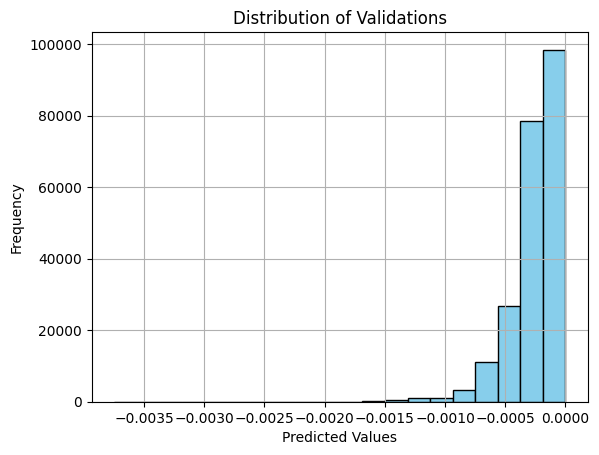

In [48]:
import matplotlib.pyplot as plt

# Assuming predictions_np is your NumPy array
plt.hist(predictions_np, bins=20, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Distribution of Validations')
plt.xlabel('Predicted Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [14]:
val = pd.DataFrame(unino)
val = pd.concat([val, test[['換匯發送名單', '換匯基因標籤', '跨售行為', 'TOTALNTAMOUNT']]], axis = 1)
val.reset_index(drop=True, inplace=True)
val

,UNINO,換匯發送名單,換匯基因標籤,跨售行為,TOTALNTAMOUNT
0,A1718392970,0,0.198148,0,0.0
1,N2737156560,0,0.987469,0,0.0
2,E1709258280,0,0.541512,0,0.0
3,E1710741550,0,0.968977,0,0.0
4,B2757469030,0,0.177445,0,0.0
...,...,...,...,...,...
220743,N2719756810,0,0.585746,0,0.0
220744,O2225506120,0,0.346764,0,0.0
220745,Q2779183550,0,0.978013,0,0.0
220746,D1776320940,0,0.553099,0,0.0


In [34]:
val.describe()

,換匯發送名單,換匯基因標籤,跨售行為,TOTALNTAMOUNT,Lift_NN|T = 0,Lift_NN|T = 1,Lift_NN
count,220748.000000,220748.000000,220748.000000,220748.0,220748.000000,220748.000000,220748.000000
mean,0.036046,0.534104,0.001803,0.0,0.002930,0.002588,-0.000342
std,0.186404,0.308709,0.042423,0.0,0.002584,0.002283,0.000310
min,0.000000,0.000000,0.000000,0.0,0.000005,0.000004,-0.005844
25%,0.000000,0.262769,0.000000,0.0,0.001305,0.001146,-0.000464
50%,0.000000,0.578979,0.000000,0.0,0.002394,0.002120,-0.000280
75%,0.000000,0.794317,0.000000,0.0,0.003887,0.003440,-0.000142
max,1.000000,1.000000,1.000000,0.0,0.048777,0.043659,0.000000


In [23]:
#val['Lift_NN|T = 0'] = predictions_np
val['Lift_NN|T = 1'] = predictions_np
val['Lift_NN'] = val['Lift_NN|T = 1'] - val['Lift_NN|T = 0']
val

,UNINO,換匯發送名單,換匯基因標籤,跨售行為,TOTALNTAMOUNT,Lift_NN|T = 0,Lift_NN|T = 1,Lift_NN,Value_NN|T = 0,Value_NN|T = 1,Value_NN
0,A1718392970,0,0.198148,0,0.0,0.000679,0.000858,1.797403e-04,202628.270182,222224.010319,19595.740137
1,N2737156560,0,0.987469,0,0.0,0.001702,0.002152,4.495864e-04,194725.371144,207755.278786,13029.907642
2,E1709258280,0,0.541512,0,0.0,0.000414,0.000524,1.104216e-04,254596.861705,274967.980937,20371.119231
3,E1710741550,0,0.968977,0,0.0,0.000930,0.001181,2.508046e-04,219946.073885,240168.303620,20222.229734
4,B2757469030,0,0.177445,0,0.0,0.000177,0.000225,4.728498e-05,236698.473975,259944.884988,23246.411012
...,...,...,...,...,...,...,...,...,...,...,...
220743,N2719756810,0,0.585746,0,0.0,0.000100,0.000127,2.697588e-05,257778.263491,279092.122840,21313.859349
220744,O2225506120,0,0.346764,0,0.0,0.000002,0.000003,6.277019e-07,224622.491381,253705.079200,29082.587819
220745,Q2779183550,0,0.978013,0,0.0,0.023879,0.029723,5.844433e-03,225664.839301,232580.695701,6915.856400
220746,D1776320940,0,0.553099,0,0.0,0.001431,0.001816,3.849181e-04,233203.724164,253532.969742,20329.245578


In [24]:
val.to_csv('/content/drive/MyDrive/Sinopac/Results/Causalml_validation_202405_results.csv')

In [42]:
!pip install scikit-uplift

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 907.7 kB/s eta 0:00:00


In [ ]:
!pip install plotly

In [43]:
import numpy as np
import pandas as pd
#import causalml
import random

%matplotlib inline
from sklift.metrics import uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift

In [45]:
from sklift.metrics import uplift_by_percentile
val['跨售行為'] = [0 if x == -1 else x for x in val['跨售行為']]
uplift_by_perc_df =  uplift_by_percentile(
    val["跨售行為"],
    val["Lift_NN"],
    val["換匯發送名單"],
    strategy="overall",
    total=False,
    std=True,
    bins=10
)

uplift_by_perc_df

ValueError: Input array is not binary. Array should contain only int or float binary values 0 (or 0.) and 1 (or 1.). Got values [0].

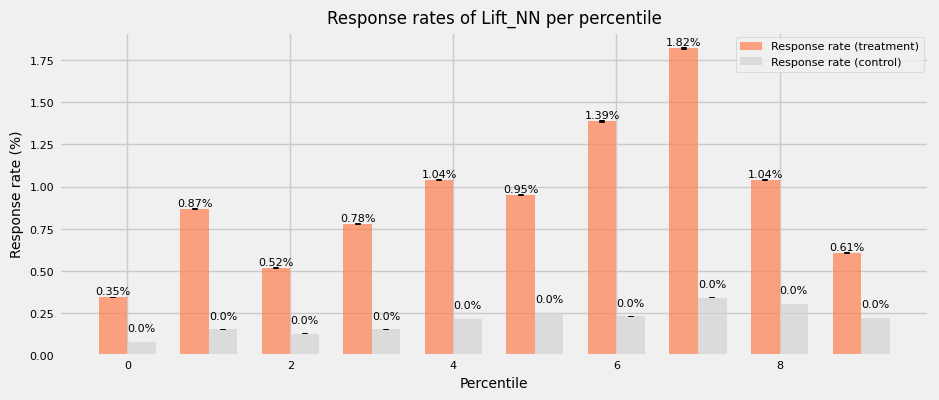

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math
from sklift.metrics import uplift_by_percentile

def plot_uplift_by_percentile(df, metric_column, bins=10):
    df['跨售行為'] = [0 if x == -1 else x for x in df['跨售行為']]

    # Fill NaN values in the metric_column with a specific value (e.g., 0)
    df[metric_column].fillna(0, inplace=True)

    uplift_by_perc_df = uplift_by_percentile(
        df["跨售行為"],
        df[metric_column],
        df["換匯發送名單"],
        strategy="by_group",
        total=False,
        std=True,
        bins=bins
    )

    fig, ax2 = plt.subplots(1, 1, figsize=(10, 4))
    #fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    '''
    # Plot the first graph (Uplift)
    bars1 = ax1.bar(
        uplift_by_perc_df.index,
        uplift_by_perc_df.uplift,
        yerr=uplift_by_perc_df.std_uplift * 2,
        color='coral',
        alpha=0.7
    )

    ax1.set_title(f'Uplift of {metric_column} per percentile', fontsize=12)
    ax1.set_ylabel('Uplift (%)', fontsize=10)

    # Adding smaller text labels on each bar for Uplift
    for bar, label in zip(bars1, uplift_by_perc_df.uplift):
        yval = bar.get_height()

        # Check for NaN values before rounding
        if not math.isnan(label):
            ax1.text(bar.get_x() + bar.get_width()/2, yval + 0.006, f'{round(label * 100)}%', ha='center', va='bottom', fontsize=8)
        else:
            ax1.text(bar.get_x() + bar.get_width()/2, yval + 0.006, 'NaN', ha='center', va='bottom', fontsize=8)'''

    # Plot the second graph (Response Rates for Treatment and Control)
    bar_width = 0.35
    index = np.arange(len(uplift_by_perc_df.index))

    bars2_treatment = ax2.bar(
        index - bar_width/2,
        uplift_by_perc_df.response_rate_treatment * 100,
        bar_width,
        label="Response rate (treatment)",
        color='coral',
        yerr=uplift_by_perc_df.std_treatment * 2,
        alpha=0.7
    )

    bars2_control = ax2.bar(
        index + bar_width/2,
        uplift_by_perc_df.response_rate_control * 100,
        bar_width,
        label="Response rate (control)",
        color='lightgrey',
        yerr=uplift_by_perc_df.std_control * 2,
        alpha=0.7
    )

    ax2.set_title(f'Response rates of {metric_column} per percentile', fontsize=12)
    ax2.set_xlabel('Percentile', fontsize=10)
    ax2.set_ylabel('Response rate (%)', fontsize=10)
    ax2.legend(fontsize=8)

    # Adding smaller text labels on each bar for Response Rates (Treatment)
    for bar, label in zip(bars2_treatment, uplift_by_perc_df.response_rate_treatment * 100):
        yval = bar.get_height()

        # Check for NaN values before rounding
        if not math.isnan(label):
            ax2.text(bar.get_x() + bar.get_width()/2, yval + 0.006, f'{round(label,2)}%', ha='center', va='bottom', fontsize=8)
        else:
            ax2.text(bar.get_x() + bar.get_width()/2, yval + 0.006, 'NaN', ha='center', va='bottom', fontsize=8)
    # Adding smaller text labels on each bar for Response Rates (Control)
    for bar, label in zip(bars2_control, uplift_by_perc_df.response_rate_control ):
        yval = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f'{round(label,2)}%', ha='center', va='bottom', fontsize=8)

    # Set smaller font size for tick labels
    ax2.tick_params(axis='both', which='major', labelsize=8)

    # Ensure that the y-axis starts from 0
    ax2.set_ylim(bottom=0)

    plt.show()

# Usage example for 'Uplift_mean' column
plot_uplift_by_percentile(val, 'Lift_NN')

In [ ]:
!pip install causalml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 13.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 10.0 MB/s eta 0:00:00
  Using cached Cython-0.29.34-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  U

In [ ]:
from causalml.metrics import plot_gain, get_cumgain
T = val
T =T[['換匯發送名單', '跨售行為',	'Lift_NN']]
cumgain = get_cumgain(T, outcome_col='跨售行為', treatment_col='換匯發送名單', normalize=True, random_seed=42)
cumgain

,Lift_NN,Random
0,0.000000,0.000000
1,0.000000,-0.000001
2,0.000000,-0.000005
3,0.000000,-0.000010
4,0.000000,-0.000018
...,...,...
218587,0.999976,0.999987
218588,0.999982,0.999993
218589,0.999988,0.999999
218590,0.999994,0.999994


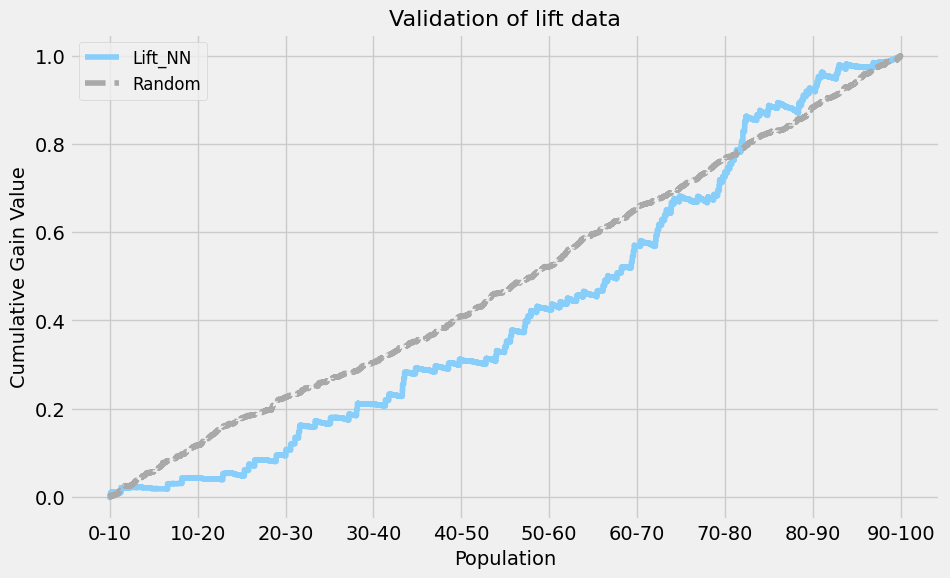

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming you have already imported pandas as pd and have the necessary dataframes

#df = pd.concat([cumgain, cumgain_1['Gi']], axis=1)
df = cumgain
#df = cumgain[:len(cumgain)//10]
x = df.index

# Define the ranges for the x-axis labels
#ranges = ['0-1', '1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9', '9-10']
ranges = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']

# Resample x to have 11 evenly spaced points
x_resampled = np.linspace(0, len(x) - 1, 10, dtype=int)

# Plotting the lines with customizations
plt.figure(figsize=(10, 6))  # Set the size of the plot
plt.plot(x, df['Lift_NN'], label='Lift_NN', color='lightskyblue')  # Set color and line width
plt.plot(x, df['Random'], label='Random', color='darkgray', linestyle='--')  # Set color and marker

# Adding labels, title, and legend with custom text size
plt.xlabel('Population', fontsize=14)  # Set x-axis label with custom text size
plt.ylabel('Cumulative Gain Value', fontsize=14)  # Set y-axis label with custom text size
plt.title('Validation of lift data', fontsize=16)  # Set title with custom text size
plt.legend(fontsize=12)  # Set legend with custom text size

# Setting x-axis ticks and labels
plt.xticks(x_resampled, ranges)

# Displaying the plot
plt.show()

### Predictions

In [72]:
import zipfile

# Specify the path to the zip file
#zip_file_path = 'data202305.csv.zip'
zip_file_path = '/content/drive/MyDrive/Sinopac/Rawdata/data202403.csv.zip'


# Unzip the folder
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')
print("Unzipped successfully.")

Unzipped successfully.


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#df = pd.read_csv('/content/drive/MyDrive/Sinopac/train_202402.csv')
df = pd.read_csv('/content/data202403.csv', index_col = 0)
df

,UNINO,年齡,公司戶記號,性別,呆帳記號_含信用卡,客戶年收入,網路會員記號,網路使用記號_行動銀行,小mma記號,網路服務記號,...,客戶行業別_醫療保健,客戶行業別_金融業,客戶行業別_電子業,對帳單寄送記號_0,對帳單寄送記號_1,對帳單寄送記號_2,信用卡VIP客戶註記_Y,外幣存款記號_Y,信用卡轉呆記號_Y,信用卡自動扣款記號_Y
0,B2779529130,30,0,2.0,0,100.0,1,3,0,1,...,False,False,False,False,False,True,False,True,False,True
1,BD522973090,41,0,2.0,0,600.0,1,3,0,1,...,False,False,False,False,False,True,False,False,False,False
2,B2791420740,46,0,2.0,0,0.0,1,0,0,8,...,False,False,False,True,False,False,False,False,False,False
3,B2791433250,45,0,2.0,0,800.0,1,0,0,1,...,False,False,False,False,False,True,False,False,False,False
4,BD527038570,37,0,2.0,0,700.0,1,3,0,1,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106674,T1791624270,61,0,1.0,0,815.0,1,0,0,3,...,False,False,False,False,False,True,False,False,False,False
1106675,T1795259650,43,0,1.0,0,450.0,1,0,0,1,...,False,False,False,False,False,True,False,False,False,False
1106676,T1796989580,48,0,1.0,0,450.0,1,2,0,3,...,False,False,False,True,False,False,False,False,False,False
1106677,T1797056980,52,0,1.0,0,0.0,1,0,0,3,...,False,False,False,True,False,False,False,False,False,False


In [26]:
num_cols = ['年齡', '薪轉員工平均薪資', '全行往來產品數_持有', '全行往來產品數_使用', '基金近1個月申購次數', '基金近3個月申購次數',
       '基金近6個月申購次數', '基金近12個月申購次數', '最近一個月刷卡筆數', '最近三個月刷卡筆數', '最近六個月刷卡筆數',
       '共同行銷合作推廣_證券', '證券月交易筆數', '證券近一年交易筆數', '證券庫存股檔數', 'TOTALNTAMOUNT',
       '外匯交易金額_近三個月']
#df.select_dtypes(include=['int64']).columns[~df.select_dtypes(include=['int64']).columns.isin(binary_columns)] #111

In [76]:
#1. Minmax
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Exclude non-numeric columns if any
numeric_cols = df.select_dtypes(include=['float64']).columns
numeric_cols = list(numeric_cols)+(num_cols) #128
#numeric_cols.append(num_cols)
# Initializing MinMaxScaler
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

df.drop(['UNINO'], axis = 1, inplace = True)
print(df.shape)

(1106679, 204)


In [32]:
#1. Minmax
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Exclude non-numeric columns if any
numeric_cols = df.select_dtypes(include=['float64']).columns
numeric_cols = numeric_cols.tolist()  # Convert Index to list

# Concatenate the lists of column names
numeric_cols += num_cols

# Assuming df is your DataFrame and columns_to_winsorize contains the column names you want to winsorize
for col in numeric_cols:
    df[col] = winsorize(df[col], limits=(0.05, 0.05))

# Initializing MinMaxScaler
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

df.drop(['UNINO'], axis = 1, inplace = True)
print(df.shape)

(1106679, 204)


In [28]:
# Load the model
model = CustomNet(input_size)
model.load_state_dict(torch.load('/content/drive/MyDrive/Model/NN_202402.pth'))
model.eval()  # Set the model to evaluation mode

CustomNet(
  (feature_extractor): Sequential(
    (0): Linear(in_features=202, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
  (branch2): Sequential(
    (0): Linear(in_features=202, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
  (output_layer): Linear(in_features=3, out_features=1, bias=True)
)

In [36]:
#T1 = pi01
#Treatment = 1
df.iloc[:, 149] = 1
#print(df.iloc[:, 149])
df.head()

,年齡,公司戶記號,性別,呆帳記號_含信用卡,客戶年收入,網路會員記號,網路使用記號_行動銀行,小mma記號,網路服務記號,網路使用記號,...,客戶行業別_醫療保健,客戶行業別_金融業,客戶行業別_電子業,對帳單寄送記號_0,對帳單寄送記號_1,對帳單寄送記號_2,信用卡VIP客戶註記_Y,外幣存款記號_Y,信用卡轉呆記號_Y,信用卡自動扣款記號_Y
0,0.250000,0.0,1.0,0.0,0.071429,1.0,3.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1,0.479167,0.0,1.0,0.0,0.428571,1.0,3.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.583333,0.0,1.0,0.0,0.000000,1.0,0.0,0.0,8.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.562500,0.0,1.0,0.0,0.571429,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.395833,0.0,1.0,0.0,0.500000,1.0,3.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
#202402
df = df.astype(float)
X_pred = torch.tensor(df.drop(['TOTALNTAMOUNT','跨售行為'],axis=1).values)  # Exclude the last column
y_pred = torch.tensor(df['跨售行為'].values)  # Last column as the target variable

criterion = nn.BCELoss()

# Set model to evaluation mode
model.eval()

# Pass test data through the model
with torch.no_grad():
    predictions = model(X_pred.float())

# Convert predictions to numpy array for further processing if needed
predictions_np = predictions.cpu().numpy()

# Print predictions
print("Predictions:", predictions_np)

# Compute the loss if needed
loss_test = criterion(predictions.squeeze(), y_pred.float())
print("Test Loss:", loss_test.item())

# Compute accuracy or other metrics if needed
# For example, for binary classification, you can calculate accuracy
#predicted_labels = (predictions > 0.5).float()  # Convert probabilities to binary predictions
#accuracy = (predicted_labels == y_test).float().mean().item()
#print("Accuracy:", accuracy)

Predictions: [[3.01663124e-04]
 [3.59505910e-04]
 [1.27326175e-05]
 ...
 [1.51437649e-04]
 [4.15924937e-04]
 [2.59245517e-05]]
Test Loss: 0.018768202513456345


In [84]:
import numpy as np

# Assuming predictions_np is your NumPy array
mean = np.mean(predictions_np)
median = np.median(predictions_np)
std_dev = np.std(predictions_np)

print("Mean:", mean)
print("Median:", median)
print("Standard Deviation:", std_dev)

Mean: 0.0021021934
Median: 0.001752294
Standard Deviation: 0.0018196108


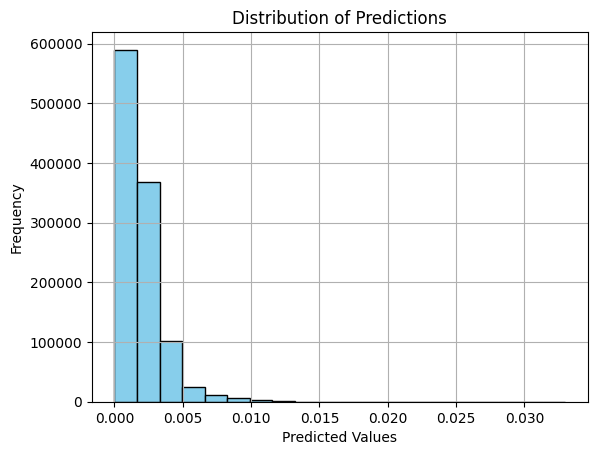

In [91]:
import matplotlib.pyplot as plt

# Assuming predictions_np is your NumPy array
plt.hist(predictions_np, bins=20, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Distribution of Predictions')
plt.xlabel('Predicted Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [38]:
import pandas as pd
#res = pd.read_csv('/content/data202403.csv', usecols=['UNINO', '換匯基因標籤', '換匯發送名單','TOTALNTAMOUNT', '跨售行為'])
#res = pd.read_csv('/content/drive/MyDrive/Sinopac/Results/Prediction_results_202403.csv', index_col = 0)
#res['NN_lift_T=0'] = predictions_np
res['NN_lift_T=1'] = predictions_np
res['NN_lift'] = res['NN_lift_T=1']-res['NN_lift_T=0']
res

,UNINO,換匯基因標籤,換匯發送名單,TOTALNTAMOUNT,跨售行為,NN_lift_T=0,NN_lift_T=1,NN_lift,NN_value_T=0,NN_value_T=1,NN_value
0,B2779529130,68.1451,0,0,0,0.000238,0.000302,0.000064,595847.927133,646047.641668,50199.714535
1,BD522973090,63.3138,0,0,0,0.000283,0.000360,0.000076,771905.244874,833713.293451,61808.048577
2,B2791420740,79.9669,0,0,0,0.000010,0.000013,0.000003,638362.073602,714925.468133,76563.394531
3,B2791433250,78.4429,0,0,0,0.000865,0.001098,0.000233,733989.259174,787682.884481,53693.625306
4,BD527038570,57.9634,0,0,0,0.000138,0.000175,0.000037,686947.136370,747669.039851,60721.903481
...,...,...,...,...,...,...,...,...,...,...,...
1106674,T1791624270,55.3538,0,0,0,0.000132,0.000167,0.000035,688767.833840,766047.526832,77279.692991
1106675,T1795259650,68.3229,0,0,0,0.001515,0.001913,0.000398,715718.209512,777164.383571,61446.174058
1106676,T1796989580,89.8181,0,0,0,0.000119,0.000151,0.000032,686792.536900,792603.692481,105811.155581
1106677,T1797056980,46.1406,0,0,0,0.000328,0.000416,0.000087,720840.183088,781952.496797,61112.313709


In [39]:
res.to_csv('/content/drive/MyDrive/Sinopac/Results/Prediction_results_202403.csv')
#1103740 rows × 6 columns

## Value


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('/content/data202402_new.csv', index_col = 0)
df

,UNINO,年齡,公司戶記號,性別,呆帳記號_含信用卡,客戶年收入,網路會員記號,網路使用記號_行動銀行,小mma記號,網路服務記號,...,客戶行業別_醫療保健,客戶行業別_金融業,客戶行業別_電子業,對帳單寄送記號_0,對帳單寄送記號_1,對帳單寄送記號_2,信用卡VIP客戶註記_Y,外幣存款記號_Y,信用卡轉呆記號_Y,信用卡自動扣款記號_Y
0,H8223079220,48,0,1.0,0,3000.0,1,1,0,1,...,False,False,False,False,False,True,False,True,False,False
1,K2779339830,39,0,2.0,0,500.0,1,3,0,1,...,False,False,False,False,False,True,False,False,False,False
2,K2779343760,36,0,2.0,0,0.0,1,3,0,1,...,False,False,False,False,False,True,False,True,False,False
3,K2779417370,35,0,2.0,0,360.0,1,2,0,1,...,False,False,False,False,False,True,False,True,False,False
4,L2727403190,51,0,2.0,0,650.0,1,2,0,1,...,True,False,False,False,False,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103735,J2725993350,61,0,2.0,0,0.0,1,0,0,8,...,False,False,False,True,False,False,False,False,False,False
1103736,J2725446790,50,0,2.0,0,0.0,1,0,0,6,...,False,False,False,True,False,False,False,False,False,False
1103737,J2726228250,56,0,2.0,0,0.0,1,2,0,1,...,False,False,False,False,False,True,False,True,False,False
1103738,H2711308250,23,0,2.0,0,280.0,1,2,0,3,...,False,False,False,False,False,True,False,False,False,False


In [51]:
df['TOTALNTAMOUNT'].describe()

count    1.103740e+06
mean     1.835759e+02
std      1.017686e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.259969e+06
Name: TOTALNTAMOUNT, dtype: float64

In [7]:
df.select_dtypes(include=['object']).columns

Index(['UNINO'], dtype='object')

In [8]:
num_cols = ['年齡', '薪轉員工平均薪資', '全行往來產品數_持有', '全行往來產品數_使用', '基金近1個月申購次數', '基金近3個月申購次數',
       '基金近6個月申購次數', '基金近12個月申購次數', '最近一個月刷卡筆數', '最近三個月刷卡筆數', '最近六個月刷卡筆數',
       '共同行銷合作推廣_證券', '證券月交易筆數', '證券近一年交易筆數', '證券庫存股檔數', 'TOTALNTAMOUNT',
       '外匯交易金額_近三個月']
#df.select_dtypes(include=['int64']).columns[~df.select_dtypes(include=['int64']).columns.isin(binary_columns)] #111

In [44]:
#1. Minmax
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Exclude non-numeric columns if any
numeric_cols = df.select_dtypes(include=['float64']).columns
numeric_cols = numeric_cols.tolist()  # Convert Index to list

# Concatenate the lists of column names
numeric_cols += num_cols

# Assuming df is your DataFrame and columns_to_winsorize contains the column names you want to winsorize
for col in numeric_cols:
    df[col] = winsorize(df[col], limits=(0.05, 0.05))

# Initializing MinMaxScaler
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

train, test = train_test_split(df, test_size=0.2, random_state=42)
train.drop(['UNINO'], axis = 1, inplace = True)
unino = test['UNINO']
test.drop(['UNINO'], axis = 1, inplace = True)
print(train.shape, test.shape)

(882992, 204) (220748, 204)


In [10]:
train.iloc[:,149]

404090     0
1043122    0
957659     0
437563     0
837328     0
          ..
110268     0
259178     1
131932     0
671155     0
121958     0
Name: 換匯發送名單, Length: 882992, dtype: int64

In [96]:
import torch
import torch.nn as nn

class MultiplyByTheta(nn.Module):
    def __init__(self, output_features):
        super(MultiplyByTheta, self).__init__()
        # Initialize theta as a parameter with 1.0 as its initial value
        # This assumes theta is a scalar. Adjust the size for vector outputs.
        self.theta = nn.Parameter(torch.ones(output_features))

    def forward(self, x):
        # Multiply input by theta
        return x * self.theta

class CustomNet(nn.Module):
    def __init__(self, input_size):
        super(CustomNet, self).__init__()
        # Branch 1
        self.fc1_branch1 = nn.Linear(input_size, 128)
        self.bn1_branch1 = nn.BatchNorm1d(128)  # Add batch normalization
        self.relu1_branch1 = nn.ReLU()
        self.fc2_branch1 = nn.Linear(128, 1)

        # Branch 2
        self.fc1_branch2 = nn.Linear(input_size, 128)
        self.bn1_branch2 = nn.BatchNorm1d(128)  # Add batch normalization
        self.relu1_branch2 = nn.ReLU()
        self.fc2_branch2 = nn.Linear(128, 2)

        # Hidden layer
        #self.fc_hidden = nn.Linear(3, 64)

        # Output layer
        self.fc_output = nn.Linear(3, 1)

        # MultiplyByTheta module
        self.multiply_theta = MultiplyByTheta(output_features=1)

    def forward(self, x):
        # Branch 1
        x_branch1 = self.relu1_branch1(self.bn1_branch1(self.fc1_branch1(x)))
        x_branch1 = self.fc2_branch1(x_branch1)

        # Branch 2
        x_branch2 = self.relu1_branch2(self.bn1_branch2(self.fc1_branch2(x)))
        T1 = x[:, 149].unsqueeze(1)
        T2 = 1 - T1
        x_branch2 = torch.sigmoid(x_branch2)  # Apply sigmoid activation before element-wise multiplication
        T1_multiplied = x_branch2[:, 0].unsqueeze(1) * T1
        T2_multiplied = x_branch2[:, 1].unsqueeze(1) * T2

        # Concatenate both branches
        x_concat = torch.cat((x_branch1, T1_multiplied, T2_multiplied), dim=1)

        # Hidden layer
        #x_hidden = torch.sigmoid(self.fc_hidden(x_concat))

        # Output layer
        output = torch.sigmoid(self.fc_output(x_concat))

        # Multiply by theta
        output = self.multiply_theta(output)

        return output

# Example usage
input_size = 202  # Number of input features
model = CustomNet(input_size)

# Print model architecture
print(model)

CustomNet(
  (fc1_branch1): Linear(in_features=202, out_features=128, bias=True)
  (bn1_branch1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1_branch1): ReLU()
  (fc2_branch1): Linear(in_features=128, out_features=1, bias=True)
  (fc1_branch2): Linear(in_features=202, out_features=128, bias=True)
  (bn1_branch2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1_branch2): ReLU()
  (fc2_branch2): Linear(in_features=128, out_features=2, bias=True)
  (fc_output): Linear(in_features=3, out_features=1, bias=True)
  (multiply_theta): MultiplyByTheta()
)


In [59]:
# Check if GPU is available and move model to GPU
if torch.cuda.is_available():
    model = model.cuda()

In [84]:
import torch
import torch.nn as nn
import torch.optim as optim
train = train.astype(float)
test = test.astype(float)
X_tensor = torch.tensor(train.drop(['TOTALNTAMOUNT','跨售行為'],axis=1).values, dtype=torch.float32)
y_tensor = torch.tensor(train['TOTALNTAMOUNT'].values, dtype=torch.float32)
X_val = torch.tensor(test.drop(['TOTALNTAMOUNT','跨售行為'],axis=1).values, dtype=torch.float32)
y_val = torch.tensor(test['TOTALNTAMOUNT'].values, dtype=torch.float32)
# Define the hyperparameter search space
learning_rates = [0.001, 0.01, 0.1]
weight_decays = [0.001, 0.01, 0.1]
epochs = [10, 20, 30]

best_loss = float('inf')
best_hyperparameters = {}

# Iterate over all hyperparameter combinations
for lr in learning_rates:
    for weight_decay in weight_decays:
        for num_epochs in epochs:
            # Define the model
            input_size = 202  # Number of input features
            model = CustomNet(input_size)

            if torch.cuda.is_available():
                device = torch.device("cuda")
                model = model.to(device)
                X_tensor = X_tensor.to(device)
                y_tensor = y_tensor.to(device)
                X_val = X_val.to(device)
                y_val = y_val.to(device)
            else:
                device = torch.device("cpu")

            # Define the loss function: Mean Squared Error (MSE)
            criterion = nn.MSELoss()

            # Define the optimizer
            optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

            # Training loop
            for epoch in range(num_epochs):
                # Forward pass
                outputs = model(X_tensor)
                loss = criterion(outputs.squeeze(), y_tensor)

                # Backward pass and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Evaluate the model on validation data
            with torch.no_grad():
                val_outputs = model(X_val)
                val_loss = criterion(val_outputs.squeeze(), y_val)

            # Update best hyperparameters if the current combination is better
            if val_loss < best_loss:
                best_loss = val_loss
                best_hyperparameters = {"lr": lr, "weight_decay": weight_decay, "epochs": num_epochs}

# Train the final model using the best hyperparameters
input_size = 202  # Number of input features
model = CustomNet(input_size)
if torch.cuda.is_available():
  device = torch.device("cuda")
  model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=best_hyperparameters["lr"], weight_decay=best_hyperparameters["weight_decay"])
criterion = nn.MSELoss()

for epoch in range(best_hyperparameters["epochs"]):
    # Forward pass
    outputs = model(X_tensor)

    loss = criterion(outputs.squeeze(), y_tensor)

    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Print the best hyperparameters
print("Best Hyperparameters:", best_hyperparameters)

Best Hyperparameters: {'lr': 0.1, 'weight_decay': 0.01, 'epochs': 30}


In [85]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Assuming you have your input data X, target variable y, and theta values in tensors
train = train.astype(float)
X_tensor = torch.tensor(train.drop(['TOTALNTAMOUNT','跨售行為'],axis=1).values, dtype=torch.float32)
y_tensor = torch.tensor(train['TOTALNTAMOUNT'].values, dtype=torch.float32)

# Define the model
input_size = 202  # Number of input features
model = CustomNet(input_size)

# Define the loss function: Mean Squared Error (MSE)
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.SGD(model.parameters(),  lr=0.1, weight_decay=0.01)
# Define the learning rate scheduler
scheduler = StepLR(optimizer, step_size=1000, gamma=0.1)  # Reduce LR by a factor of 0.1 every 1000 epochs

# Training loop
num_epochs = 50000
desired_loss = 0.005

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_tensor)
    loss = criterion(outputs.squeeze(), y_tensor)

    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Update the learning rate
    scheduler.step()

    # Print loss every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Check if the loss is below the desired threshold
    if loss.item() < desired_loss:
        print(f'Loss reached the desired threshold of {desired_loss}. Stopping training...')
        break

Epoch [1/50000], Loss: 0.2079
Epoch [2/50000], Loss: 0.1814
Epoch [3/50000], Loss: 0.1597
Epoch [4/50000], Loss: 0.1415
Epoch [5/50000], Loss: 0.1262
Epoch [6/50000], Loss: 0.1131
Epoch [7/50000], Loss: 0.1019
Epoch [8/50000], Loss: 0.0921
Epoch [9/50000], Loss: 0.0836
Epoch [10/50000], Loss: 0.0761
Epoch [11/50000], Loss: 0.0696
Epoch [12/50000], Loss: 0.0638
Epoch [13/50000], Loss: 0.0586
Epoch [14/50000], Loss: 0.0540
Epoch [15/50000], Loss: 0.0499
Epoch [16/50000], Loss: 0.0462
Epoch [17/50000], Loss: 0.0428
Epoch [18/50000], Loss: 0.0398
Epoch [19/50000], Loss: 0.0371
Epoch [20/50000], Loss: 0.0346
Epoch [21/50000], Loss: 0.0323
Epoch [22/50000], Loss: 0.0303
Epoch [23/50000], Loss: 0.0284
Epoch [24/50000], Loss: 0.0267
Epoch [25/50000], Loss: 0.0251
Epoch [26/50000], Loss: 0.0236
Epoch [27/50000], Loss: 0.0223
Epoch [28/50000], Loss: 0.0210
Epoch [29/50000], Loss: 0.0199
Epoch [30/50000], Loss: 0.0188
Epoch [31/50000], Loss: 0.0178
Epoch [32/50000], Loss: 0.0169
Epoch [33/50000],

In [86]:
# Save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/Model/NN_value_202402.pth')

In [40]:
# Load the model
model = CustomNet(input_size)
model.load_state_dict(torch.load('/content/drive/MyDrive/Model/NN_value_202402.pth'))
model.eval()  # Set the model to evaluation mode

CustomNet(
  (fc1_branch1): Linear(in_features=202, out_features=128, bias=True)
  (bn1_branch1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1_branch1): ReLU()
  (fc2_branch1): Linear(in_features=128, out_features=1, bias=True)
  (fc1_branch2): Linear(in_features=202, out_features=128, bias=True)
  (bn1_branch2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1_branch2): ReLU()
  (fc2_branch2): Linear(in_features=128, out_features=2, bias=True)
  (fc_output): Linear(in_features=3, out_features=1, bias=True)
  (multiply_theta): MultiplyByTheta()
)

In [62]:
test.iloc[:,149] = 1

In [63]:
# Prediction
# Assuming you have your test input data X_test in a tensor
#test_data = torch.tensor(test.values, dtype=torch.float32)
test = test.astype(float)
X_test = torch.tensor(test.drop(['TOTALNTAMOUNT','跨售行為'],axis=1).values)  # Exclude the last column
y_test = torch.tensor(test['TOTALNTAMOUNT'].values)  # Last column as the target variable

# Define the loss function: Mean Squared Error (MSE)
criterion = nn.MSELoss()

# Set model to evaluation mode
model.eval()

# Pass test data through the model
with torch.no_grad():
    predictions = model(X_test.float())

# Convert predictions to numpy array for further processing if needed
predictions_np = predictions.cpu().numpy()

# Print predictions
print("Predictions:", predictions_np)

# Compute the loss if needed
loss_test = criterion(predictions.squeeze(), y_test.float())
print("Test Loss:", loss_test.item())

Predictions: [[0.06816752]
 [0.06372922]
 [0.08434681]
 ...
 [0.07134445]
 [0.07777159]
 [0.06033587]]
Test Loss: 0.005686281714588404


In [64]:
# Define the min and max values for each feature
min_val = df['TOTALNTAMOUNT'].min()
max_val = df['TOTALNTAMOUNT'].max()

# Apply the inverse transform manually
predictions_np = (predictions_np * (max_val - min_val)) + min_val
predictions_np

array([[222224.01031859],
       [207755.27878612],
       [274967.98093656],
       ...,
       [232580.69570072],
       [253532.96974222],
       [196693.06850099]])

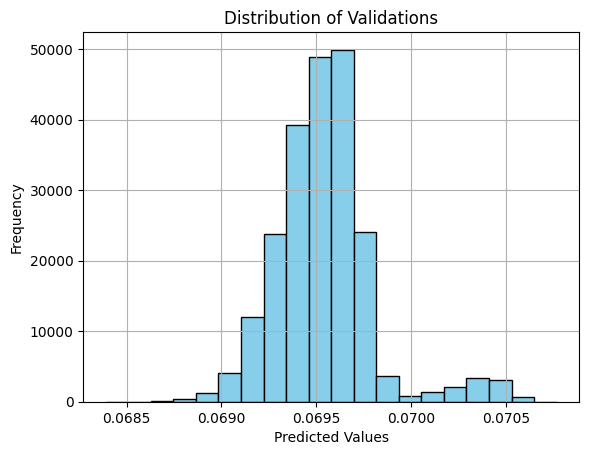

In [ ]:
import matplotlib.pyplot as plt

# Assuming predictions_np is your NumPy array
plt.hist(predictions_np, bins=20, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Distribution of Validations')
plt.xlabel('Predicted Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [19]:
val = pd.read_csv('/content/drive/MyDrive/Sinopac/Results/Causalml_validation_202405_results.csv', index_col = 0)
val

,UNINO,換匯發送名單,換匯基因標籤,跨售行為,TOTALNTAMOUNT,Lift_NN|T = 0,Lift_NN|T = 1,Lift_NN,Value_NN|T = 0,Value_NN|T = 1,Value_NN
0,A1718392970,0,0.198148,0,0.0,0.005170,0.004610,-0.000560,202628.270182,222224.010319,19595.740137
1,N2737156560,0,0.987469,0,0.0,0.002209,0.001936,-0.000273,194725.371144,207755.278786,13029.907642
2,E1709258280,0,0.541512,0,0.0,0.000868,0.000751,-0.000116,254596.861705,274967.980937,20371.119231
3,E1710741550,0,0.968977,0,0.0,0.003354,0.002922,-0.000432,219946.073885,240168.303620,20222.229734
4,B2757469030,0,0.177445,0,0.0,0.001510,0.001329,-0.000181,236698.473975,259944.884988,23246.411012
...,...,...,...,...,...,...,...,...,...,...,...
220743,N2719756810,0,0.585746,0,0.0,0.000482,0.000422,-0.000060,257778.263491,279092.122840,21313.859349
220744,O2225506120,0,0.346764,0,0.0,0.000007,0.000006,-0.000001,224622.491381,253705.079200,29082.587819
220745,Q2779183550,0,0.978013,0,0.0,0.002708,0.002348,-0.000360,225664.839301,232580.695701,6915.856400
220746,D1776320940,0,0.553099,0,0.0,0.003336,0.002938,-0.000398,233203.724164,253532.969742,20329.245578


In [65]:
#val['Value_NN|T = 0'] = predictions_np
val['Value_NN|T = 1'] = predictions_np
val['Value_NN'] = val['Value_NN|T = 1'] - val['Value_NN|T = 0']
val

,UNINO,換匯發送名單,換匯基因標籤,跨售行為,TOTALNTAMOUNT,Lift_NN|T = 0,Lift_NN|T = 1,Lift_NN,Value_NN|T = 0,Value_NN|T = 1,Value_NN
0,A1718392970,0,0.198148,0,0.0,0.005170,0.004610,-0.000560,202628.270182,222224.010319,19595.740137
1,N2737156560,0,0.987469,0,0.0,0.002209,0.001936,-0.000273,194725.371144,207755.278786,13029.907642
2,E1709258280,0,0.541512,0,0.0,0.000868,0.000751,-0.000116,254596.861705,274967.980937,20371.119231
3,E1710741550,0,0.968977,0,0.0,0.003354,0.002922,-0.000432,219946.073885,240168.303620,20222.229734
4,B2757469030,0,0.177445,0,0.0,0.001510,0.001329,-0.000181,236698.473975,259944.884988,23246.411012
...,...,...,...,...,...,...,...,...,...,...,...
220743,N2719756810,0,0.585746,0,0.0,0.000482,0.000422,-0.000060,257778.263491,279092.122840,21313.859349
220744,O2225506120,0,0.346764,0,0.0,0.000007,0.000006,-0.000001,224622.491381,253705.079200,29082.587819
220745,Q2779183550,0,0.978013,0,0.0,0.002708,0.002348,-0.000360,225664.839301,232580.695701,6915.856400
220746,D1776320940,0,0.553099,0,0.0,0.003336,0.002938,-0.000398,233203.724164,253532.969742,20329.245578


In [66]:
val.to_csv('/content/drive/MyDrive/Sinopac/Results/Causalml_validation_202405_results.csv')

In [69]:
import pandas as pd
import numpy as np
def response_value_by_percentile(true_value, lift_value, treatment, group, bins=10):

    true_value, lift_value, treatment = np.array(true_value), np.array(lift_value), np.array(treatment)
    order = np.argsort(lift_value, kind='mergesort')[::-1]

    trmnt_flag = 1 if group == 'treatment' else 0


    y_true_bin = np.array_split(true_value[order], bins)
    trmnt_bin = np.array_split(treatment[order], bins)
    group_size = np.array([len(y[trmnt == trmnt_flag]) for y, trmnt in zip(y_true_bin, trmnt_bin)])
    response_value = np.array([np.mean(y[trmnt == trmnt_flag]) for y, trmnt in zip(y_true_bin, trmnt_bin)])
    variance = np.array([np.var(y[trmnt == trmnt_flag]) for y, trmnt in zip(y_true_bin, trmnt_bin)])
    #variance = np.multiply(response_value, np.divide((1 - response_value), group_size))

    return response_value, variance, group_size


def uplift_value_by_percentile(true_value, lift_value, treatment, bins=10, string_percentiles=True):
    true_value, lift_value, treatment = np.array(true_value), np.array(lift_value), np.array(treatment)

    response_value_trmnt, variance_trmnt, n_trmnt = response_value_by_percentile(
        true_value, lift_value, treatment, group='treatment', bins=bins)

    response_value_ctrl, variance_ctrl, n_ctrl = response_value_by_percentile(
        true_value, lift_value, treatment, group='control', bins=bins)

    uplift_scores = response_value_trmnt - response_value_ctrl
    uplift_variance = variance_trmnt + variance_ctrl

    percentiles = [round(p * 100 / bins) for p in range(1, bins + 1)]

    if string_percentiles:
        percentiles = [f"0-{percentiles[0]}"] + \
            [f"{percentiles[i]}-{percentiles[i + 1]}" for i in range(len(percentiles) - 1)]


    df = pd.DataFrame({
        'percentile': percentiles,
        'n_treatment': n_trmnt,
        'n_control': n_ctrl,
        'response_value_treatment': response_value_trmnt,
        'response_value_control': response_value_ctrl,
        'uplift': uplift_scores
    })

    std_treatment = np.sqrt(variance_trmnt)
    std_control = np.sqrt(variance_ctrl)
    std_uplift = np.sqrt(uplift_variance)

    df.loc[:, 'std_treatment'] = std_treatment
    df.loc[:, 'std_control'] = std_control
    df.loc[:, 'std_uplift'] = std_uplift

    df = df \
        .set_index('percentile', drop=True, inplace=False) \
        .astype({'n_treatment': 'int32', 'n_control': 'int32'})

    return df

In [70]:
val['TOTALNTAMOUNT'] = df['TOTALNTAMOUNT']
val['TOTALNTAMOUNT'].describe()

count    2.207480e+05
mean     1.971747e+02
std      9.007271e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.410616e+06
Name: TOTALNTAMOUNT, dtype: float64

In [71]:
uplift_value_by_percentile(
        val["TOTALNTAMOUNT"],
        val['Value_NN'],
        val["換匯發送名單"],
        bins=10
    )

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,n_treatment,n_control,response_value_treatment,response_value_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,0,22075,NaN,176.554247,NaN,NaN,7030.042991,NaN
10-20,0,22075,NaN,229.890419,NaN,NaN,9003.404632,NaN
20-30,0,22075,NaN,141.921721,NaN,NaN,4768.786606,NaN
30-40,0,22075,NaN,246.057848,NaN,NaN,11943.590257,NaN
40-50,0,22075,NaN,77.827950,NaN,NaN,3762.454504,NaN
50-60,0,22075,NaN,201.680544,NaN,NaN,9298.573807,NaN
60-70,0,22075,NaN,243.556602,NaN,NaN,12375.953887,NaN
70-80,0,22075,NaN,272.315334,NaN,NaN,11029.408745,NaN
80-90,0,22074,NaN,135.659645,NaN,NaN,5914.901782,NaN


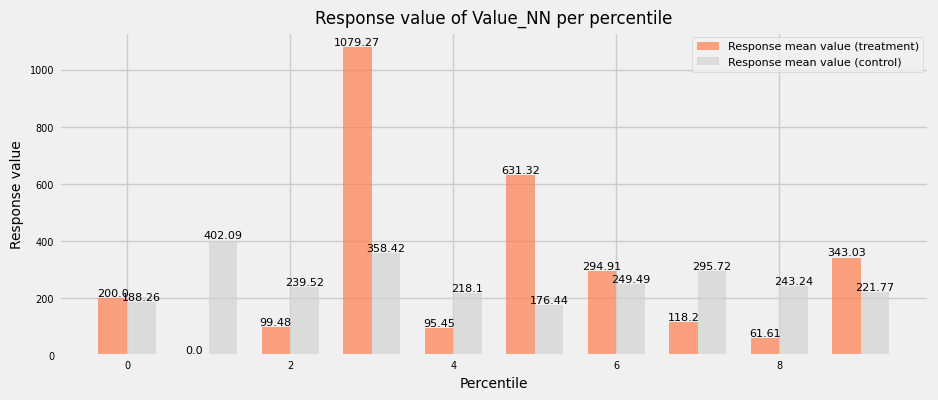

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math
from sklift.metrics import uplift_by_percentile

def plot_uplift_value_by_percentile(df, metric_column, bins=10):

    # Fill NaN values in the metric_column with a specific value (e.g., 0)
    df[metric_column].fillna(0, inplace=True)

    uplift_by_perc_df = uplift_value_by_percentile(
        df["TOTALNTAMOUNT"],
        df[metric_column],
        df["換匯發送名單"],
        bins=10
    )
    fig, ax2 = plt.subplots(1, 1, figsize=(10, 4))

    # Plot the second graph (Response Rates for Treatment and Control)
    bar_width = 0.35
    index = np.arange(len(uplift_by_perc_df.index))

    bars2_treatment = ax2.bar(
        index - bar_width/2,
        uplift_by_perc_df.response_value_treatment,
        bar_width,
        label="Response mean value (treatment)",
        color='coral',
        #yerr=uplift_by_perc_df.std_treatment * 2,
        alpha=0.7
    )

    bars2_control = ax2.bar(
        index + bar_width/2,
        uplift_by_perc_df.response_value_control,
        bar_width,
        label="Response mean value (control)",
        color='lightgrey',
        #yerr=uplift_by_perc_df.std_control * 2,
        alpha=0.7
    )

    ax2.set_title(f'Response value of {metric_column} per percentile', fontsize=12)
    ax2.set_xlabel('Percentile', fontsize=10)
    ax2.set_ylabel('Response value', fontsize=10)
    ax2.legend(fontsize=8)

    # Adding smaller text labels on each bar for Response Rates (Treatment)
    for bar, label in zip(bars2_treatment, uplift_by_perc_df.response_value_treatment):
        yval = bar.get_height()

        # Check for NaN values before rounding
        if not math.isnan(label):
            ax2.text(bar.get_x() + bar.get_width()/2, yval + 0.0001, f'{round(label, 2)}', ha='center', va='bottom', fontsize=8)
        else:
            ax2.text(bar.get_x() + bar.get_width()/2, yval + 0.00001, 'NaN', ha='center', va='bottom', fontsize=8)

    # Adding smaller text labels on each bar for Response Rates (Control)
    for bar, label in zip(bars2_control, uplift_by_perc_df.response_value_control):
        yval = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2, yval + 0.0005, f'{round(label, 2)}', ha='center', va='bottom', fontsize=8)

    # Set smaller font size for tick labels
    ax2.tick_params(axis='both', which='major', labelsize=7)

    # Ensure that the y-axis starts from 0
    ax2.set_ylim(bottom=0)

    plt.show()

# Usage example for 'Uplift_mean' column
plot_uplift_value_by_percentile(val, 'Value_NN')

In [ ]:
from causalml.metrics import plot_gain, get_cumgain
T = val
T =T[['換匯發送名單', 'TOTALNTAMOUNT',	'Value_NN']]
#T['Value_NN'] = T['Value_NN']/(max_val - min_val)
cumgain = get_cumgain(T, outcome_col='TOTALNTAMOUNT', treatment_col='換匯發送名單', normalize=True, random_seed=42)
cumgain

,Value_NN,Random
0,0.000000,0.000000
1,0.000000,0.000000
2,0.000000,0.000000
3,0.000000,0.000000
4,0.000000,0.000000
...,...,...
218587,0.999816,0.999903
218588,0.999862,0.999949
218589,0.999908,0.999995
218590,0.999954,0.999954


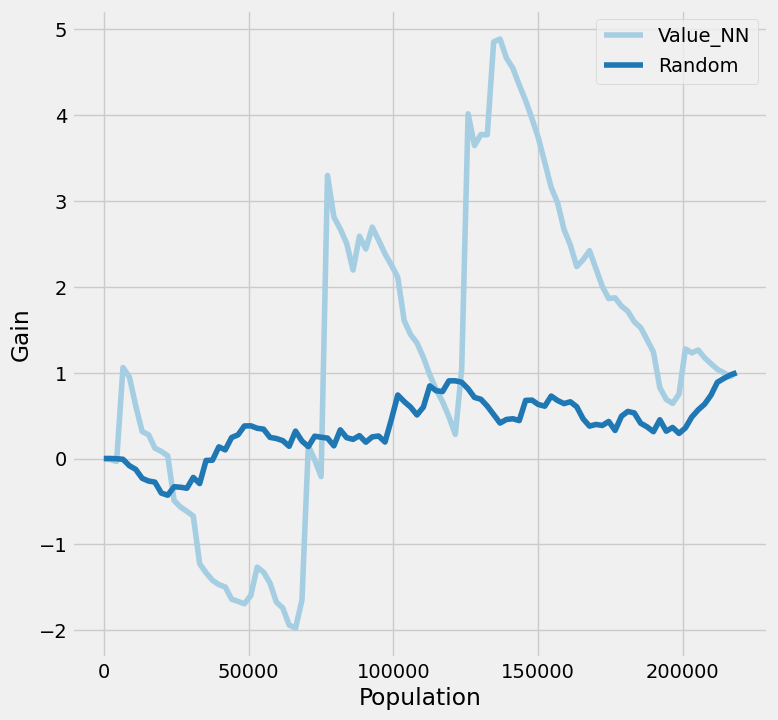

In [ ]:
plot_gain(T, outcome_col='TOTALNTAMOUNT', treatment_col='換匯發送名單', normalize=True, random_seed=42)

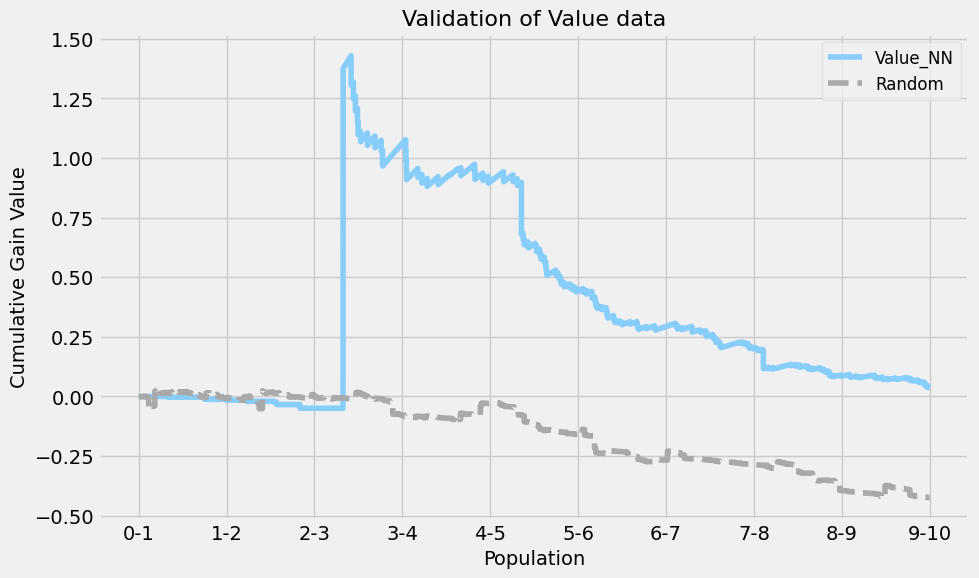

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming you have already imported pandas as pd and have the necessary dataframes

#df = pd.concat([cumgain, cumgain_1['Gi']], axis=1)
#df = cumgain
df = cumgain[:len(cumgain)//10]
x = df.index

# Define the ranges for the x-axis labels
ranges = ['0-1', '1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9', '9-10']
#ranges = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']

# Resample x to have 11 evenly spaced points
x_resampled = np.linspace(0, len(x) - 1, 10, dtype=int)

# Plotting the lines with customizations
plt.figure(figsize=(10, 6))  # Set the size of the plot
plt.plot(x, df['Value_NN'], label='Value_NN', color='lightskyblue')  # Set color and line width
plt.plot(x, df['Random'], label='Random', color='darkgray', linestyle='--')  # Set color and marker

# Adding labels, title, and legend with custom text size
plt.xlabel('Population', fontsize=14)  # Set x-axis label with custom text size
plt.ylabel('Cumulative Gain Value', fontsize=14)  # Set y-axis label with custom text size
plt.title('Validation of Value data', fontsize=16)  # Set title with custom text size
plt.legend(fontsize=12)  # Set legend with custom text size

# Setting x-axis ticks and labels
plt.xticks(x_resampled, ranges)

# Displaying the plot
plt.show()

###Predictions

In [ ]:
import zipfile

# Specify the path to the zip file
#zip_file_path = 'data202305.csv.zip'
zip_file_path = '/content/drive/MyDrive/Sinopac/Rawdata/data202403.csv.zip'


# Unzip the folder
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')
print("Unzipped successfully.")

Unzipped successfully.


In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#df = pd.read_csv('/content/drive/MyDrive/Sinopac/train_202402.csv')
df = pd.read_csv('/content/data202403.csv', index_col = 0)
df

,UNINO,年齡,公司戶記號,性別,呆帳記號_含信用卡,客戶年收入,網路會員記號,網路使用記號_行動銀行,小mma記號,網路服務記號,...,客戶行業別_醫療保健,客戶行業別_金融業,客戶行業別_電子業,對帳單寄送記號_0,對帳單寄送記號_1,對帳單寄送記號_2,信用卡VIP客戶註記_Y,外幣存款記號_Y,信用卡轉呆記號_Y,信用卡自動扣款記號_Y
0,B2779529130,30,0,2.0,0,100.0,1,3,0,1,...,False,False,False,False,False,True,False,True,False,True
1,BD522973090,41,0,2.0,0,600.0,1,3,0,1,...,False,False,False,False,False,True,False,False,False,False
2,B2791420740,46,0,2.0,0,0.0,1,0,0,8,...,False,False,False,True,False,False,False,False,False,False
3,B2791433250,45,0,2.0,0,800.0,1,0,0,1,...,False,False,False,False,False,True,False,False,False,False
4,BD527038570,37,0,2.0,0,700.0,1,3,0,1,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106674,T1791624270,61,0,1.0,0,815.0,1,0,0,3,...,False,False,False,False,False,True,False,False,False,False
1106675,T1795259650,43,0,1.0,0,450.0,1,0,0,1,...,False,False,False,False,False,True,False,False,False,False
1106676,T1796989580,48,0,1.0,0,450.0,1,2,0,3,...,False,False,False,True,False,False,False,False,False,False
1106677,T1797056980,52,0,1.0,0,0.0,1,0,0,3,...,False,False,False,True,False,False,False,False,False,False


In [93]:
num_cols = ['年齡', '薪轉員工平均薪資', '全行往來產品數_持有', '全行往來產品數_使用', '基金近1個月申購次數', '基金近3個月申購次數',
       '基金近6個月申購次數', '基金近12個月申購次數', '最近一個月刷卡筆數', '最近三個月刷卡筆數', '最近六個月刷卡筆數',
       '共同行銷合作推廣_證券', '證券月交易筆數', '證券近一年交易筆數', '證券庫存股檔數', 'TOTALNTAMOUNT',
       '外匯交易金額_近三個月']
#df.select_dtypes(include=['int64']).columns[~df.select_dtypes(include=['int64']).columns.isin(binary_columns)] #111

In [95]:
#1. Minmax
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Exclude non-numeric columns if any
numeric_cols = df.select_dtypes(include=['float64']).columns
numeric_cols = numeric_cols.tolist()  # Convert Index to list

# Concatenate the lists of column names
numeric_cols += num_cols

min_val = df['TOTALNTAMOUNT'].min()
max_val = df['TOTALNTAMOUNT'].max()


# Assuming df is your DataFrame and columns_to_winsorize contains the column names you want to winsorize
for col in numeric_cols:
    df[col] = winsorize(df[col], limits=(0.05, 0.05))

# Initializing MinMaxScaler
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
df.drop(['UNINO'], axis = 1, inplace = True)
print(df.shape)

(1106679, 204)


In [97]:
# Load the model
model = CustomNet(input_size)
model.load_state_dict(torch.load('/content/drive/MyDrive/Model/NN_value_202402.pth'))
model.eval()  # Set the model to evaluation mode

CustomNet(
  (fc1_branch1): Linear(in_features=202, out_features=128, bias=True)
  (bn1_branch1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1_branch1): ReLU()
  (fc2_branch1): Linear(in_features=128, out_features=1, bias=True)
  (fc1_branch2): Linear(in_features=202, out_features=128, bias=True)
  (bn1_branch2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1_branch2): ReLU()
  (fc2_branch2): Linear(in_features=128, out_features=2, bias=True)
  (fc_output): Linear(in_features=3, out_features=1, bias=True)
  (multiply_theta): MultiplyByTheta()
)

In [105]:
#T1 = pi01
#Treatment = 1
df.iloc[:, 149] = 1
df.iloc[:, 149]

0          1.0
1          1.0
2          1.0
3          1.0
4          1.0
          ... 
1106674    1.0
1106675    1.0
1106676    1.0
1106677    1.0
1106678    1.0
Name: 換匯發送名單, Length: 1106679, dtype: float64

In [106]:
#202402
df = df.astype(float)
X_pred = torch.tensor(df.drop(['TOTALNTAMOUNT','跨售行為'],axis=1).values)  # Exclude the last column
y_pred = torch.tensor(df['TOTALNTAMOUNT'].values)  # Last column as the target variable

# Define the loss function: Mean Squared Error (MSE)
criterion = nn.MSELoss()

# Set model to evaluation mode
model.eval()

# Pass test data through the model
with torch.no_grad():
    predictions = model(X_pred.float())

# Convert predictions to numpy array for further processing if needed
predictions_np = predictions.cpu().numpy()

# Print predictions
print("Predictions:", predictions_np)

# Compute the loss if needed
loss_test = criterion(predictions.squeeze(), y_pred.float())
print("Test Loss:", loss_test.item())

Predictions: [[0.0646048 ]
 [0.08337137]
 [0.07149258]
 ...
 [0.07926041]
 [0.07819529]
 [0.07348567]]
Test Loss: 0.005664740689098835


In [107]:
# Define the min and max values for each feature
#min_val = df['TOTALNTAMOUNT'].min()
#max_val = df['TOTALNTAMOUNT'].max()

# Apply the inverse transform manually
predictions_np = (predictions_np * (max_val - min_val)) + min_val

In [ ]:
import numpy as np

# Assuming predictions_np is your NumPy array
mean = np.mean(predictions_np)
median = np.median(predictions_np)
std_dev = np.std(predictions_np)

print("Mean:", mean)
print("Median:", median)
print("Standard Deviation:", std_dev)

Mean: 347493.5365901088
Median: 347590.4564475417
Standard Deviation: 932.2542967516615


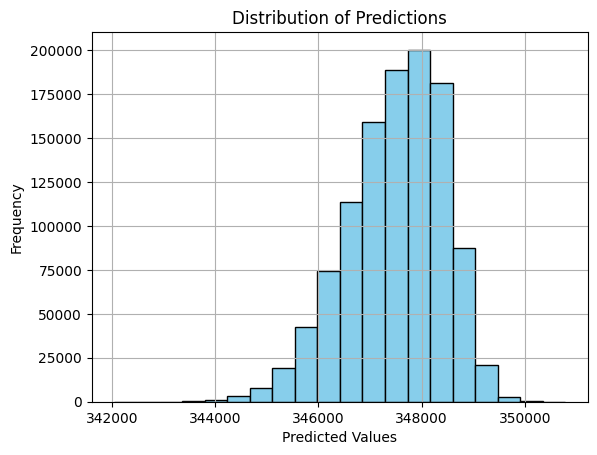

In [ ]:
import matplotlib.pyplot as plt

# Assuming predictions_np is your NumPy array
plt.hist(predictions_np, bins=20, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Distribution of Predictions')
plt.xlabel('Predicted Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [103]:
res = pd.read_csv('/content/drive/MyDrive/Sinopac/Results/Prediction_results_202403.csv', index_col = 0)
res

,UNINO,換匯基因標籤,換匯發送名單,TOTALNTAMOUNT,跨售行為,NN_lift_T=0,NN_lift_T=1,NN_lift
0,B2779529130,68.1451,0,0,0,0.000789,0.000696,-0.000093
1,BD522973090,63.3138,0,0,0,0.001345,0.001180,-0.000165
2,B2791420740,79.9669,0,0,0,0.000031,0.000027,-0.000004
3,B2791433250,78.4429,0,0,0,0.004781,0.004200,-0.000581
4,BD527038570,57.9634,0,0,0,0.001138,0.001003,-0.000135
...,...,...,...,...,...,...,...,...
1106674,T1791624270,55.3538,0,0,0,0.000790,0.000692,-0.000098
1106675,T1795259650,68.3229,0,0,0,0.005532,0.004873,-0.000659
1106676,T1796989580,89.8181,0,0,0,0.000488,0.000425,-0.000063
1106677,T1797056980,46.1406,0,0,0,0.001471,0.001282,-0.000189


In [108]:
import pandas as pd
#res = pd.read_csv('/content/data202402.csv', usecols=['UNINO', '換匯基因標籤', '換匯發送名單','TOTALNTAMOUNT', '跨售行為'])
res['NN_value_T=1'] = predictions_np
#res['NN_value_T=0'] = predictions_np
res['NN_value'] = res['NN_value_T=1']-res['NN_value_T=0']
res

,UNINO,換匯基因標籤,換匯發送名單,TOTALNTAMOUNT,跨售行為,NN_lift_T=0,NN_lift_T=1,NN_lift,NN_value_T=0,NN_value_T=1,NN_value
0,B2779529130,68.1451,0,0,0,0.000789,0.000696,-0.000093,595847.927133,646047.641668,50199.714535
1,BD522973090,63.3138,0,0,0,0.001345,0.001180,-0.000165,771905.244874,833713.293451,61808.048577
2,B2791420740,79.9669,0,0,0,0.000031,0.000027,-0.000004,638362.073602,714925.468133,76563.394531
3,B2791433250,78.4429,0,0,0,0.004781,0.004200,-0.000581,733989.259174,787682.884481,53693.625306
4,BD527038570,57.9634,0,0,0,0.001138,0.001003,-0.000135,686947.136370,747669.039851,60721.903481
...,...,...,...,...,...,...,...,...,...,...,...
1106674,T1791624270,55.3538,0,0,0,0.000790,0.000692,-0.000098,688767.833840,766047.526832,77279.692991
1106675,T1795259650,68.3229,0,0,0,0.005532,0.004873,-0.000659,715718.209512,777164.383571,61446.174058
1106676,T1796989580,89.8181,0,0,0,0.000488,0.000425,-0.000063,686792.536900,792603.692481,105811.155581
1106677,T1797056980,46.1406,0,0,0,0.001471,0.001282,-0.000189,720840.183088,781952.496797,61112.313709


In [110]:
# Import pandas
import pandas as pd

# Set the display option to suppress scientific notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)
res.iloc[:,5:].describe()

,NN_lift_T=0,NN_lift_T=1,NN_lift,NN_value_T=0,NN_value_T=1,NN_value
count,1106679.00000,1106679.00000,1106679.00000,1106679.00000,1106679.00000,1106679.00000
mean,0.00210,0.00185,-0.00025,689199.49073,749720.03267,60520.54195
std,0.00182,0.00161,0.00021,64505.62048,66282.69384,16871.67245
min,0.00000,0.00000,-0.00419,339365.50636,381827.94583,-5398.16646
25%,0.00097,0.00085,-0.00034,649151.29122,710109.48975,48725.43164
50%,0.00175,0.00154,-0.00021,692184.37037,751155.09026,57923.24329
75%,0.00278,0.00245,-0.00012,734878.48552,794568.44686,70878.60438
max,0.03718,0.03299,-0.00000,888069.94559,981924.26640,140212.10812


In [109]:
res.to_csv('/content/drive/MyDrive/Sinopac/Results/Prediction_results_202403.csv')
#1103740 rows × 6 columns

In [ ]:
output = res.drop(['UNINO'], axis = 1)
output.to_csv('/content/output.csv')